# Local-Global-Trend(LGT) Example

In [1]:
import pandas as pd
import numpy as np
from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components

## Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries from Jan 2010 - June 2018. This aims to mimick the dataset from the paper "Predicting the Present with Bayesian Structural Time Series" by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

In [2]:
DATA_FILE = "./data/iclaims_example.csv"
date_col = 'week'
response_col = 'claims'
raw_df = pd.read_csv(DATA_FILE, parse_dates=[date_col])
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

We preprocess the data by log transformation to turn model from `additive` to `multiplicative`.

In [3]:
df=raw_df.copy()
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

In [4]:
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


### Train / Test Split

In [5]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [6]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


## MAP Fit and Predict

In [7]:
lgt=LGTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [8]:
%%time
lgt.fit(df=train_df)

CPU times: user 211 ms, sys: 13.9 ms, total: 225 ms
Wall time: 540 ms


In [9]:
predicted_df = lgt.predict(df=test_df)

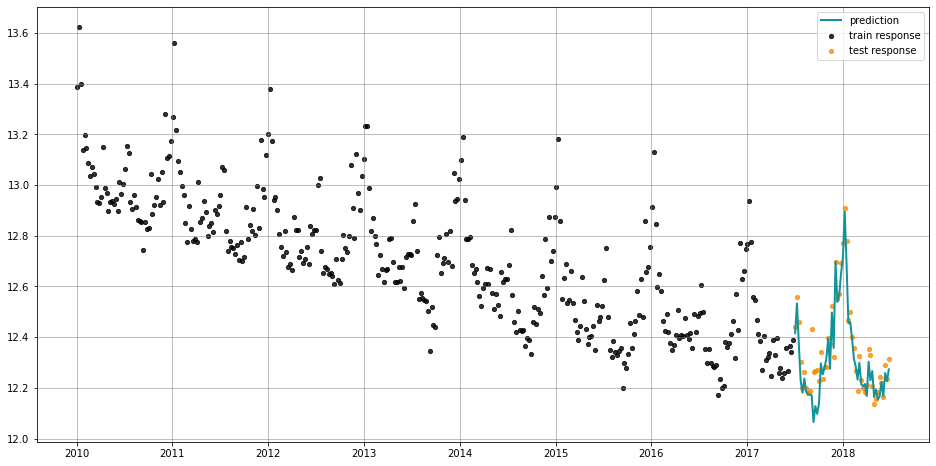

In [10]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col, 
                    pred_col='prediction', 
                    test_actual_df=test_df)

## MCMC Fit and Predict

In [11]:
lgt=LGTFull(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    prediction_percentiles=[5, 95],
)

In [12]:
%%time
lgt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 72.9 ms, sys: 70.7 ms, total: 144 ms
Wall time: 7.47 s


In [13]:
predicted_df = lgt.predict(df=test_df)

In [14]:
predicted_df.tail(5)

,week,prediction_lower,prediction,prediction_upper
47,2018-05-27,12.099949,12.232984,12.330652
48,2018-06-03,12.060341,12.173674,12.293869
49,2018-06-10,12.118473,12.262561,12.408782
50,2018-06-17,12.097858,12.239122,12.341881
51,2018-06-24,12.193468,12.281816,12.383324


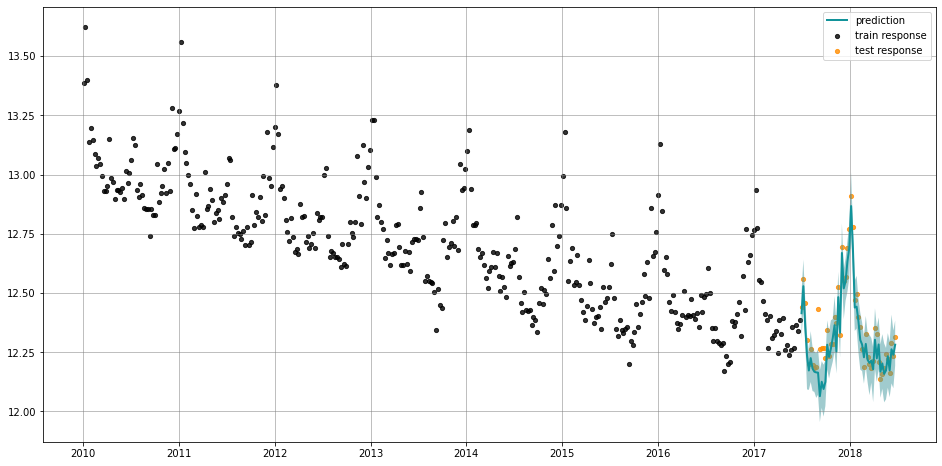

In [15]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt.date_col, actual_col=lgt.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## Fit with Regressors & Decmpose Prediction

### Fit with regressors

In [19]:
lgt=LGTFull(
    response_col=response_col,
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
    prediction_percentiles=[5, 95],
)

In [20]:
%%time
lgt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 84.3 ms, sys: 83.1 ms, total: 167 ms
Wall time: 9.92 s


### Decompose Prediction

We can use `decompose=True` to decompose prediction into `trend`, `seasonality` and `regression` components. This command only works with point estimate.

In [22]:
# make prediction in both train and test period
predicted_df = lgt.predict(df=df, decompose=True)
predicted_df.tail(5)

,week,prediction_lower,prediction,prediction_upper,trend_lower,trend,trend_upper,seasonality_lower,seasonality,seasonality_upper,regression_lower,regression,regression_upper
438,2018-05-27,12.141717,12.220374,12.328540,12.293877,12.389288,12.522518,-0.222905,-0.165211,-0.126634,0.000050,0.001649,0.003483
439,2018-06-03,12.071502,12.155615,12.256296,12.278757,12.388479,12.497914,-0.289455,-0.231388,-0.181169,0.002061,0.004089,0.006654
440,2018-06-10,12.180654,12.259956,12.367401,12.285392,12.388965,12.515677,-0.191039,-0.133754,-0.090308,0.004898,0.012213,0.020513
441,2018-06-17,12.124853,12.240902,12.348367,12.264731,12.390887,12.517330,-0.220066,-0.162596,-0.118805,0.003326,0.010661,0.017965
442,2018-06-24,12.184551,12.279159,12.386493,12.269579,12.398319,12.520437,-0.175234,-0.120847,-0.078531,0.005390,0.012118,0.020016


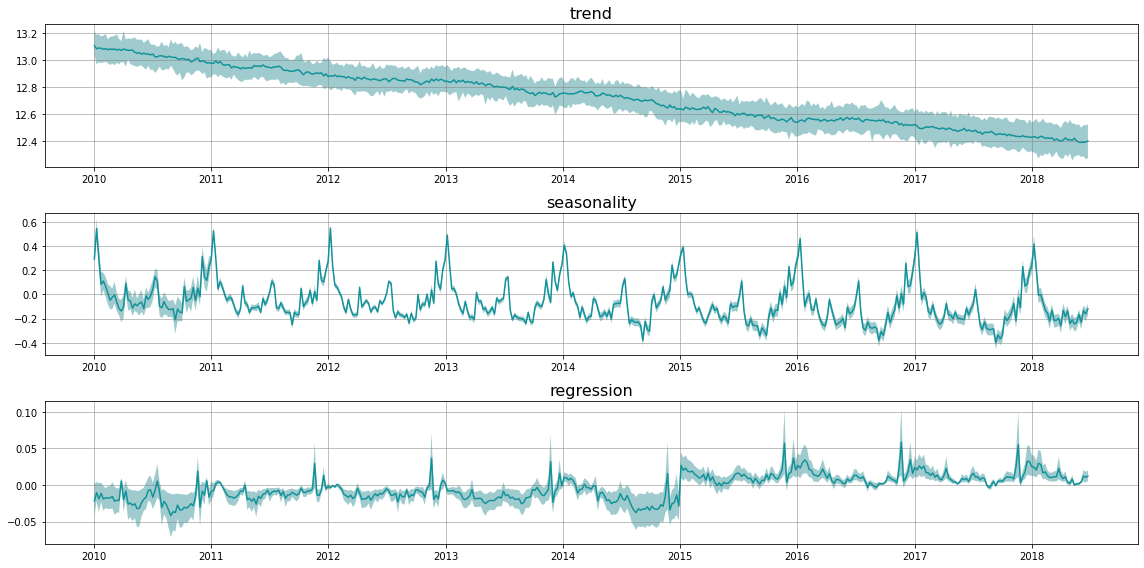

In [26]:
plot_predicted_components(predicted_df=predicted_df, date_col=date_col)